In [ ]:
import os

In [ ]:
if "COLAB_GPU" in os.environ:
 #   !pip install PyMuPDF # for reading PDFs using python
  #  !pip install tqdm # for progress bars
   # !pip install accelerate # for quantization model loading
    #!pip install bitsandbytes # for quantization models (less storage/memory usage)
    !pip install flash-attn --no-build-isolation # for faster attention computation

In [ ]:
pip install PyMuPDF tqdm accelerate bitsandbytes

In [ ]:
#!pip uninstall -y torch torchvision torchaudio transformers sentence-transformers
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
#!pip install -U transformers sentence-transformers

In [ ]:
import os
import requests

pdf_path = "Human-Nutrition.pdf"

if not os.path.exists(pdf_path):
    print("Downloading PDF...")

    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

    filename = pdf_path
    response = requests.get(url)

    if response.status_code == 200:
        with open(filename, "wb") as f:
            f.write(response.content)
        print(f"Downloaded {filename}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")
else:
    print(f"{pdf_path} already exists.")

In [ ]:
import fitz # PyMuPDF

from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    # minor formatting to clean up text
    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> str:
    # Open the PDF file
    document = fitz.open(pdf_path)
    pages_and_texts = []

    # Iterate through each page and extract text
    for page_number, page in tqdm(enumerate(document)):
        #print(page_number, page)
        text = page.get_text()
        text = text_formatter(text)
        pages_and_texts.append({
        "page_number": page_number - 41,
        "page_char_count": len(text),
        "page_word_count": len(text.split(" ")),
        "Page_sentence_count_raw": len(text.split(". ")),
        "page_token_count": len(text)/4, # rough estimate: 1 token ~= 4 characters
        "text": text
        })

    return pages_and_texts


In [ ]:
pages_and_texts = open_and_read_pdf(pdf_path = pdf_path)
pages_and_texts[:2]  # Display the first two pages' data

In [ ]:
import random

random_pages = random.sample(pages_and_texts, k=3)
random_pages

In [ ]:
%pip install pandas

import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

In [ ]:
df.describe().round(2)

Potentially each page can be embedded with embedding models of input capacity ~ 300

### Chunking

One sentence can be one chunk or one page can also be one chunk

Top 1 or top 3 chunks which are closest to the prompt are passed to the LLM.

### Testing 5 chunking strategies

#### Fixed size chunking

In [ ]:
def chunk_text(text: str, chunk_size: int = 500)-> list:

    chunks = []
    current_chunk = ''
    words = text.split()

    for word in words:
        # check if adding the next word exceeds chunk size
        if len(current_chunk) + len(word) + 1 <= chunk_size:
            current_chunk += (word + ' ')
        else:
            # store cuurrent chunk and start a new one
            chunks.append(current_chunk.strip())
            current_chunk = word + ' '

    # add any remaining text as a chunk
    if current_chunk:
        chunks.append(current_chunk.strip())

    return chunks


In [ ]:
def chunk_pdf_pages(pages_and_texts: list, chunk_size: int = 500) -> list[dict]:

    all_chunks = []
    for page in pages_and_texts:
        page_number = page['page_number']
        page_text = page['text']
        chunks = chunk_text(page_text, chunk_size=chunk_size)

        for i, chunk in enumerate(chunks):
            all_chunks.append({
                "page_number": page_number,
                "chunk_index": i,
                "chunk_text": chunk,
                "chunk_word_count": len(chunk.split()),
                "chunk_char_count": len(chunk),
                "chunk_token_count": len(chunk)/4  # rough estimate
            })

    return all_chunks
    

In [ ]:
chunked_pages = chunk_pdf_pages(pages_and_texts, chunk_size=500)
print(f"Total chunks created: {len(chunked_pages)}")
print(f"First chunk: (page {chunked_pages[0]['page_number']}) {chunked_pages[0]['chunk_text'][:200]}")

In [ ]:
chunked_pages[500]

In [ ]:
import random
[random.randrange(100)]

#### Semantic chunking

In [ ]:
!pip -q install --upgrade "sentence-transformers==3.0.1" "transformers<5,>=4.41" scikit-learn nltk

In [ ]:
!pip install tqdm

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import nltk
nltk.download('punkt', quiet=True)

semantic_model = SentenceTransformer('all-MiniLM-L6-v2')

def semantic_chunk_text(text: str, similairty_threshold: float = 0.8, max_tokens: int = 500) -> list:
    """"
    Splits text into semantic chunks based on similarity threshold and max token limit.
    """
    sentences = nltk.sent_tokenize(text)
    if not sentences:
        return []
    
    embeddings = semantic_model.encode(sentences)

    chunks = []
    current_chunk = [sentences[0]]
    current_embedding = embeddings[0]

    for i in range(1, len(sentences)):
        sim = cosine_similarity([current_embedding], [embeddings[i]])[0][0]
        chunked_token_count = len(" ".join(current_chunk)) // 4  # rough estimate

        if sim>= similairty_threshold and chunked_token_count< max_tokens:
            current_chunk.append(sentences[i])
            current_embedding = np.mean([current_embedding, embeddings[i]], axis=0)
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = [sentences[i]]
            current_embedding = embeddings[i]

    if current_chunk:
        chunks.append(" ".join(current_chunk))


    return chunks

In [ ]:
from tqdm.auto import tqdm
def semantic_chunk_pdf_pages(pages_and_texts: list, similairty_threshold: float = 0.8, max_tokens: int = 500) -> list[dict]:

    all_chunks = []
    for page in tqdm(pages_and_texts, desc="Semantic Chunking Pages"):
        page_number = page['page_number']
        page_text = page['text']
        chunks = semantic_chunk_text(page_text, similairty_threshold=similairty_threshold, max_tokens=max_tokens)

        for i, chunk in enumerate(chunks):
            all_chunks.append({
                "page_number": page_number,
                "chunk_index": i,
                "chunk_text": chunk,
                "chunk_word_count": len(chunk.split()),
                "chunk_char_count": len(chunk),
                "chunk_token_count": len(chunk)/4  # rough estimate
            })

    return all_chunks

In [ ]:
nltk.download('punkt_tab')
semantic_chunked_pages = semantic_chunk_pdf_pages(pages_and_texts, similairty_threshold=0.75, max_tokens=500)

print(f"Total semantic chunks created: {len(semantic_chunked_pages)}")
print(f"First semantic chunk: (page {semantic_chunked_pages[0]['page_number']}) {semantic_chunked_pages[0]['chunk_text'][:200]}")

Here there are more number of chunks and the chunk sizes are relatively small. That is because the cosine similarity beween the sentence in one chunk with the sentence in another chunk maybe less than the threshold given (here 0.75). If we want bigger chunks, we can reduce the threshold!

In [ ]:
semantic_chunked_pages[502]

#### Recursive chunking 

Here the recursive chunking is done, first chunking where there are double new lines (\n\n), then single new line (\n) and then a sentence.

In [ ]:
import nltk
nltk.download('punkt')
from tqdm.auto import tqdm

def recursive_chunk_text(text: str, max_chunk_size: int = 1000, min_chunk_size: int = 100) -> list:
    """"
    Recursively splits text into chunks based on max and min chunk size.
    First splits by sections, then newlines, then sentences.
    """

    def split_chunk(chunk: str) -> list:

        # Base case: if text is within max chunk size, return as single chunk
        if len(chunk) <= max_chunk_size:
            return [chunk]
        
        # Try splitting by double newlines (sections)
        sections = chunk.split("\n\n")
        if len(sections) > 1:
            result = []
            for section in sections:
                if section.strip():  # avoid empty sections
                    result.extend(split_chunk(section.strip()))
            return result

        # Try splitting by single newlines (paragraphs)
        sections = chunk.split("\n")
        if len(sections) > 1:
            result = []
            for section in sections:
                if section.strip():  # avoid empty sections
                    result.extend(split_chunk(section.strip()))
            return result
        
        # Fall back, split by sentences
        sentences = nltk.sent_tokenize(chunk)
        chunks, current_chunk, current_size = [], [], 0

        for sentence in sentences:
            if current_size + len(sentence) > max_chunk_size:
                if current_chunk:
                    chunks.append(" ".join(current_chunk))
                current_chunk = [sentence]
                current_size = len(sentence)
            else:
                current_chunk.append(sentence)
                current_size += len(sentence)

        if current_chunk:
            chunks.append(" ".join(current_chunk))

        return chunks
    
    return split_chunk(text)

In [ ]:
def recursive_chunk_pdf_pages(pages_and_texts: list, max_chunk_size: int = 1000, min_chunk_size: int = 100) -> list[dict]:
    """
    Recursively chunks PDF pages' text into smaller chunks.
    """

    all_chunks = []
    for page in tqdm(pages_and_texts, desc="Recursive Chunking Pages"):
        page_number = page['page_number']
        page_text = page['text']
        chunks = recursive_chunk_text(page_text, max_chunk_size=max_chunk_size, min_chunk_size=min_chunk_size)

        for i, chunk in enumerate(chunks):
            all_chunks.append({
                "page_number": page_number,
                "chunk_index": i,
                "chunk_text": chunk,
                "chunk_word_count": len(chunk.split()),
                "chunk_char_count": len(chunk),
                "chunk_token_count": len(chunk)/4  # rough estimate
            })

    return all_chunks

In [ ]:
recursive_chunked_pages = recursive_chunk_pdf_pages(pages_and_texts, max_chunk_size=1000, min_chunk_size=100)
print(f"Total recursive chunks created: {len(recursive_chunked_pages)}")
print(f"First recursive chunk: (page {recursive_chunked_pages[0]['page_number']}) {recursive_chunked_pages[0]['chunk_text'][:200]}")

In [ ]:
recursive_chunked_pages[500]

In [ ]:
text = "Title\n\nParagraph one line 1.\nParagraph one line 2.\n\nParagraph two.\n\n\nParagraph three after extra blank."

sections = text.split("\n\n")
print(sections)
# [
#   'Title',
#   'Paragraph one line 1.\nParagraph one line 2.',
#   'Paragraph two.',
#   '\nParagraph three after extra blank'
# ]

# Iterate sections
for i, s in enumerate(sections):
    print(f"Section {i}:")
    print(s)

In [ ]:
## Understanding the stripping of empty sections

text = "Title\n\nParagraph one.\n\n\n   \n\nParagraph two."
sections = text.split("\n\n")
# sections: ['Title', 'Paragraph one.', '', '   ', 'Paragraph two.']
print(sections)

result = []
for section in sections:
    if section.strip():         # '' and '   ' are skipped
        result.extend([section.strip()])

print(result)
# ['Title', 'Paragraph one.', 'Paragraph two.']

#### Structure Based chunking

Use RegEx method to mactch strings: Here try to see which common string appears in the beginning of every chapter, so that it can be exploited to split each chapter into chunks 

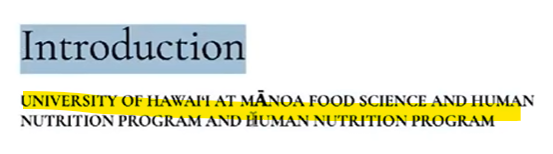

In [ ]:
import re
import random
import textwrap

In [ ]:
def _is_chapter_header_page(text: str) -> bool:
    """
    Maches the recurring header: UNIVERSITY OF HAWAII .....
    """
    return re.search(r'University\s+of\s+Hawai', text, flags=re.IGNORECASE) is not None

In [ ]:
def _guess_title_from_page(text: str) -> str:
    """
    Best guess -> text before University of Hawai
    """
    m = re.search(r'University\s+of\s+Hawai', text, flags=re.IGNORECASE)
    if m:
        title = text[:m.start()].strip()
        # clean it up a bit
        title = re.sub(r'\s+', ' ', title).strip()  # replace multiple spaces with single space
        if 10<= len(title)<=100:
            return title
        
    # fallback
    title = re.sub(r'\s+', ' ', text).strip()
    return title[:100]  if title else "Untitled Chapter"


In [ ]:
def chapter_wise_chunks(pages_and_texts: list[dict]) -> list[dict]:
    """
    Organizes pages into chapters based on recurring header and chunks them.
    Returns a dict of chapter titles to their respective chunks.
    """

    if not pages_and_texts:
        return []
    
    chapter_starts = []
    for i, page in enumerate(pages_and_texts):
        text = page['text']
        if _is_chapter_header_page(text):
            chapter_starts.append(i)

    # if nothing detected, treat whole doc as single chapter
    if not chapter_starts:
        #treat whole doc as single chapter
        all_text = " ".join([page['text'] for page in pages_and_texts]).strip()
        return [{
            "chapter_index": 0,
            "chapter_title": _guess_title_from_page(pages_and_texts[0]['text']),
            "page_start": pages_and_texts[0]['page_number'],
            "page_end": pages_and_texts[-1]['page_number'],
            "chunk_text": all_text,
            "chunk_word_count": len(all_text.split()),
            "chunk_char_count": len(all_text),
            "chunk_token_count": round(len(all_text)/4,2)  # rough estimate
        }]
    
    # Build chapter ranges (start -> next chapter start -1)
    chapter_chunks = []
    for ci, s in enumerate(chapter_starts):
        e = (chapter_starts[ci + 1] - 1) if (ci + 1) < len(chapter_starts) else (len(pages_and_texts) - 1)
        if s > e:
            continue  # skip invalid ranges

        pages = pages_and_texts[s:e + 1]
        text = " ".join([page['text'] for page in pages]).strip()
        chapter_title = _guess_title_from_page(pages[0]['text'])


        chapter_chunks.append({
            "chapter_index": ci,
            "chapter_title": chapter_title,
            "page_start": pages[0]['page_number'],
            "page_end": pages[-1]['page_number'],
            "chunk_text": text,
            "chunk_word_count": len(text.split()),
            "chunk_char_count": len(text),
            "chunk_token_count": round(len(text)/4,2)  # rough estimate
        })

    return chapter_chunks

    

In [ ]:
structure_chunked_pages = chapter_wise_chunks(pages_and_texts)
print(f"Total chapters detected: {len(structure_chunked_pages)}")
print(f"First chapter: (pages {structure_chunked_pages[0]['page_start']} - {structure_chunked_pages[0]['page_end']}) {structure_chunked_pages[0]['chapter_title']} \n First chapter text: {structure_chunked_pages[0]['chunk_text'][:1000]}")

In [ ]:
structure_chunked_pages[50]

#### LLM based chunking

In [ ]:
import os
os.environ['OPENAI_API_KEY'] = Your_API_key

In [ ]:
from openai import OpenAI
from typing import List, Dict
from tqdm.auto import tqdm


In [ ]:
client = OpenAI()

def llm_based_chunk(text: str, chunk_size: int = 100, model: str = "gpt-4o-mini") -> List[str]:
    """
    Uses LLM to find semantically coherent chunk boundaries
    around a target chunk size.
    """

    def get_chunk_boundary(text_segment: str) -> int:
        """
        Ask the LLM where to split within the text segment.
        Returns an index (int) within the text where to split.
        """
        prompt = f"""
        Analyze the text segment and identify the best point to split it 
        into two semantically coherent chunks.
        The split should occur near {chunk_size} characters.

        Text Segment:
        \"\"\"{text_segment}\"\"\"
        Return only the integer index (character position) within the text 
        where the split should occur. Do not return any explanation.
        """

        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a helpful assistant that identifies chunk boundaries in text."},
                {"role": "user", "content": prompt}
            ],
            temperature=0
        )

        # Extract and sanitize the response
        split_str = response.choices[0].message.content.strip()
        split_point = int(split_str)

        return split_point
    
    chunks = []
    remaining_text = text

    while len(remaining_text) > chunk_size:
        text_window = remaining_text[:chunk_size * 2]  # look ahead a bit
        split_point = get_chunk_boundary(text_window)

        # safety checks
        if split_point < 100 or split_point > len(text_window) - 100:
            split_point = chunk_size  # fallback to fixed chunk size

        chunks.append(remaining_text[:split_point].strip())
        remaining_text = remaining_text[split_point:].strip()

    if remaining_text:
        chunks.append(remaining_text)

    return chunks


In [ ]:
def llm_based_chunk_pdf_pages(pages_and_texts: List[Dict], chunk_size: int = 1000, model: str = "gpt-4o-mini") -> List[Dict]:
    """
    Uses LLM to chunk PDF pages' text into smaller chunks.
    """

    all_chunks = []
    for page in tqdm(pages_and_texts, desc="LLM-Based Chunking Pages"):
        page_number = page['page_number']
        page_text = page['text']
        chunks = llm_based_chunk(page_text, chunk_size=chunk_size, model=model)

        for i, chunk in enumerate(chunks):
            all_chunks.append({
                "page_number": page_number,
                "chunk_index": i,
                "chunk_text": chunk,
                "chunk_word_count": len(chunk.split()),
                "chunk_char_count": len(chunk),
                "chunk_token_count": len(chunk)/4  # rough estimate
            })
            

    return all_chunks

In [ ]:
llm_chunked_pages = llm_based_chunk_pdf_pages(pages_and_texts, chunk_size=800, model="gpt-4o-mini")
print(f"Total LLM-based chunks created: {len(llm_chunked_pages)}")
print(f"First LLM-based chunk: (page {llm_chunked_pages[0]['page_number']}) {llm_chunked_pages[0]['chunk_text'][:200]}")